In [1]:
!git clone -l -s git://github.com/darkshadow013/Land-cover-ML himanshu-garg
%cd himanshu-garg
!ls

Cloning into 'himanshu-garg'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 24 (delta 4), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (24/24), 18.13 MiB | 17.63 MiB/s, done.
Resolving deltas: 100% (4/4), done.
/content/himanshu-garg
Data				IP_CNN_SVM_BEST.sav  parameters.py
IP_CNN_samples3200_epoch200.h5	IP_SVM_BEST.sav      README.md


In [2]:
# Import the necessary libraries
!pip install spectral
from spectral import *
import scipy
import scipy.io as sio
import scipy.ndimage
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from skimage.transform import rotate
#from spectral import *
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras import backend as K
from keras.utils import np_utils
import itertools
import os
import random
from random import shuffle
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
mat_x = sio.loadmat('/content/himanshu-garg/Data/Indian_pines_corrected.mat')['indian_pines_corrected']        # shape 145*145*220
mat_y = sio.loadmat('/content/himanshu-garg/Data/Indian_pines_gt.mat')['indian_pines_gt']                      # shape 145*145

In [0]:
h, w, b = 145, 145, 200           # height,width and band of image
P_S = 5                         # patch size (window size)
oversampling = 1               # Turn true to make distribution of samples across various classes to be uniform
no_of_patch = 200                # if oversampling is true enter no of patches for each class

In [0]:
x_np, y_np = np.array(mat_x), np.array(mat_y)
x, y = x_np.reshape(h,w,b), y_np.reshape(h,w)       # x and y are equal to x_np and y_np

In [0]:
x = x.astype(float)
for i in range(b):
  x[:,:,i] = x[:,:,i]/np.max(x[:,:,i])

In [0]:
pad_width = int( (P_S-1)/2 )
padded_x = np.pad(x,[(pad_width,pad_width),(pad_width,pad_width),(0,0)],'edge')

In [0]:
X,Y = [],[]
for i in range(h):
  for j in range(w):
    if(y[i][j]!= 0):
      patch = padded_x[i:i+P_S,j:j+P_S,:]
      X.append(patch)
      Y.append(y[i][j]-1)

In [0]:
x_train, x_test, y_train, y_test = train_test_split( X, Y, test_size=0.25,stratify=Y, random_state=10)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]), array([  35, 1071,  622,  178,  362,  547,   21,  358,   15,  729, 1841,
        445,  154,  949,  289,   70]))


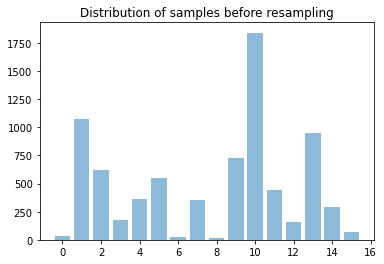

In [11]:
u_c = np.unique(y_train,return_counts=True)
print(u_c)
plt.bar( u_c[0],u_c[1], align='center', alpha=0.5)
plt.title('Distribution of samples before resampling')
plt.show()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]), array([200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200,
       200, 200, 200]))


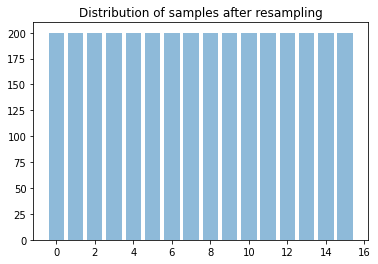

In [12]:
output_classes = len(np.unique(y_np))-1
classes = []
if(oversampling):
    for i in range(output_classes):
        classes.append([])
        
    for i in range(len(y_train)):
        classes[y_train[i]].append(x_train[i])
        
    for c in range(output_classes):
        temp = classes[c]
        for i in range( int( no_of_patch / len(classes[c]) ) ):
            classes[c]+=temp
        shuffle(classes[c])
        classes[c] = classes[c][0:no_of_patch]
        
    x_train,y_train = [],[]
    for c in range(output_classes):
        x_train.extend( classes[c] )
        for i in range(len(classes[c])):
            y_train.append(c)
            
    randomize = np.arange(len(x_train))
    np.random.shuffle(randomize)
    x_train = [x_train[i] for i in randomize]
    y_train = [y_train[i] for i in randomize]
    
    u_c = np.unique(y_train,return_counts=True)
    print(u_c)
    plt.bar( u_c[0],u_c[1], align='center', alpha=0.5)
    plt.title('Distribution of samples after resampling')
    plt.show()

In [0]:
x_train,x_test,y_train,y_test = np.array(x_train),np.array(x_test),np.array(y_train),np.array(y_test)

In [14]:
BAND = 200
BATCH_SIZE = 100
LEARNING_RATE = 0.01
CONV_1_CHANNELS = 500
CONV_2_CHANNELS = 100
FC_1_UNITS = 200
FC_2_UNITS = 84
FC_3_UNITS = 16

#Kernel Sizes
CONV_K_S = 5
POOL_K_S = 2

STRIDES = 2
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[3], 
                               x_train.shape[1], x_train.shape[2]))
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[3], 
                             x_test.shape[1], x_test.shape[2]))
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
print(x_train.shape[0],x_train.shape[1],x_train.shape[2],x_train.shape[3])

3200 200 5 5


In [0]:
input_shape= x_train[0].shape

In [0]:
# Define the model structure
model = Sequential()
model.add(Conv2D(500, (3,3) , activation='relu', input_shape=input_shape, strides = STRIDES, padding = 'same'))
model.add(MaxPooling2D(pool_size = POOL_K_S, padding = 'same', strides = STRIDES))
model.add(Conv2D(100, (3,3) , activation='relu',strides = STRIDES, padding = 'same'))
model.add(MaxPooling2D(pool_size = POOL_K_S, padding = 'same', strides = STRIDES))
model.add(Flatten())
model.add(Dense(200, activation='relu'))
model.add(Dense(84, activation='relu'))
model.add(Dense(16,activation='softmax'))

In [0]:
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=25, 
                              min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="checkpoint.hdf5", verbose=1, 
                              save_best_only=True)
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, 
                              metrics=['accuracy'])

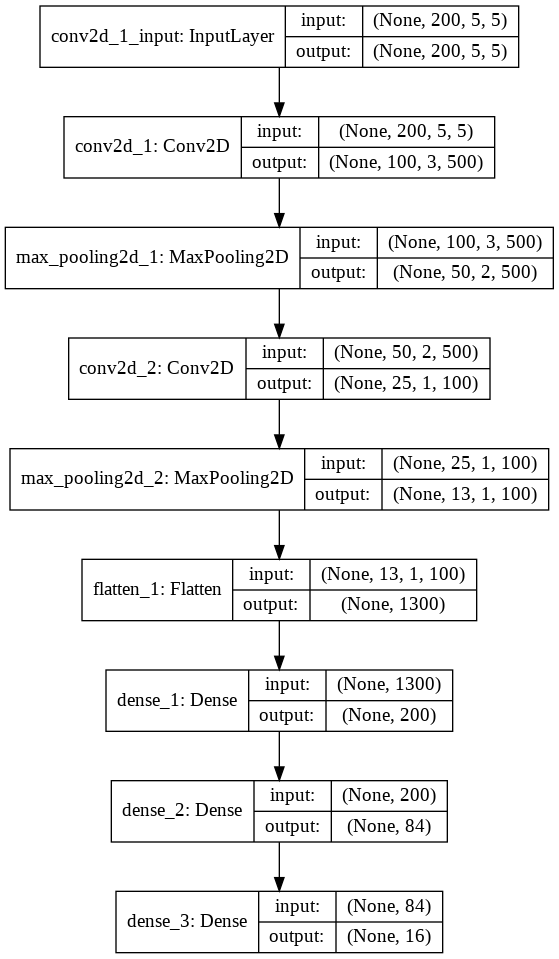

In [19]:
from keras.utils import plot_model
if not os.path.exists('/content/Files_CNN'):
    os.makedirs('/content/Files_CNN')
plot_model(model, to_file='/content/Files_CNN/CNN_model.png', show_shapes=True)

In [0]:
if(os.path.exists('/content/himanshu-garg/IP_CNN_samples3200_epoch200.h5')):
    # load the model architecture and weights
    model.load_weights("/content/himanshu-garg/IP_CNN_samples3200_epoch200.h5")
else:
    # Start to train model 
    history = model.fit(x_train, y_train, 
                        batch_size=32, 
                        epochs=200, 
                        verbose=1, 
                        validation_data=(x_test, y_test),
                        callbacks=[reduce_lr, checkpointer],
                        shuffle=True)
    # save the model with h5py
    import h5py
    model.save('/content/himanshu-garg/IP_CNN_samples3200_epoch200.h5')


In [21]:
score = model.evaluate(x_test, y_test, batch_size=32)

2563/2563 [==============================] - 7s 3ms/step


In [22]:
Test_Loss = score[0]*100
Test_accuracy = score[1]*100
print(Test_Loss,Test_accuracy)    


46.39047641006243 85.48575639724731


In [0]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = 5
numComponents = 30

def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    return patch

# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height-PATCH_SIZE+1):
    for j in range(width-PATCH_SIZE+1):
        p = int(PATCH_SIZE/2)
        target = y[i+p][j+p]
        if target == 0 :
            continue
        else :
            image_patch=Patch(x,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[2],image_patch.shape[0],image_patch.shape[1]).astype('float32')                                   
            prediction = (model.predict_classes(X_test_image))                         
            outputs[i+p][j+p] = prediction+1

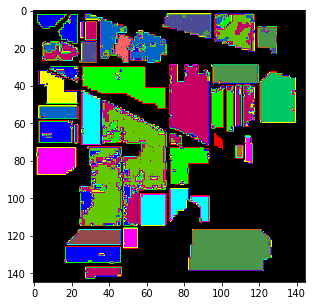

In [25]:
predict_image = imshow(classes=outputs.astype(int), figsize=(5, 5))